In [418]:
import cv2
import matplotlib.pyplot as plt
import os
from glob import glob
import numpy as np
from tqdm import tqdm

In [108]:
sample1 = cv2.imread("./data/ytdataset/images_nopad/training/100_Paul Rice “Waltz for Ella” FREE SHEET MUSIC P Barton FEURICH piano.mp4/0500.png")
sample1 = cv2.cvtColor(sample1, cv2.COLOR_BGR2RGB)
sample2 = cv2.imread("./data/MIDItest/images/testing/500_10.mp4/0500.png")
sample2 = cv2.cvtColor(sample2, cv2.COLOR_BGR2RGB)
sample3 = cv2.imread("./data/bommelpiano/images/training/600_The Bonnie Banks o Loch Lomond - Piano Arrangement.mp4/0500.png")
sample3 = cv2.cvtColor(sample3, cv2.COLOR_BGR2RGB)

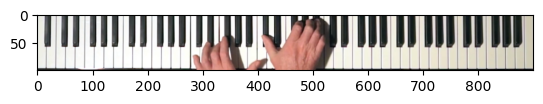

In [109]:
plt.imshow(sample1)

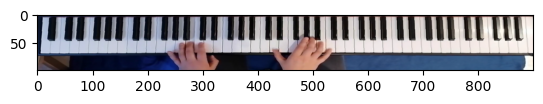

In [110]:
plt.imshow(sample2, cmap="gray")

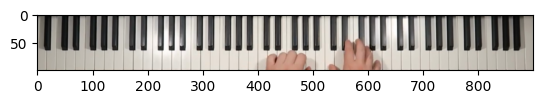

In [111]:
plt.imshow(sample3, cmap="gray")

---------------

In [35]:
label_files = sorted(glob("./data/ytdataset/labels_audeo/training/*"))
label_files_2 = sorted(glob("./data/bommelpiano/labels/training/*"))
label_files_test1 = sorted(glob("./data/ytdataset/labels_audeo/testing/*"))
label_files_test2 = sorted(glob("./data/MIDItest/labels/testing/*"))
label_files_test3 = sorted(glob("./data/bommelpiano/labels/testing/*"))

ds_names = ["yt_train", "bommel_train", "yt_test", "midi_test", "bommel_test"]

In [36]:
check_file_list = [
    label_files, 
    label_files_2, 
    label_files_test1, 
    label_files_test2, 
    label_files_test3]

In [37]:
def make_onset(roll: np.array):
    onset = np.zeros(roll.shape)
    for j in range(roll.shape[0]):
        if j != 0:
            onset[j][np.setdiff1d(roll[j].nonzero(),roll[j - 1].nonzero())] = 1
        else:
            onset[j][roll[j].nonzero()] = 1
    return onset

In [38]:
onset_sum_list = []
for filelist in check_file_list:
    onset_sum = []
    for label in tqdm(filelist):
        label_dict = np.load(label, allow_pickle=True)
        label_np = np.array(list(label_dict.values()))
        label_np = (label_np > 0).astype(int)

        onset_np = make_onset(label_np)

        onset_sum.append(np.sum(onset_np, axis=0))
    onset_sum = np.stack(onset_sum)
    onset_sum_list.append(onset_sum)

100% 182/182 [01:17<00:00,  2.34it/s]
100% 30/30 [00:05<00:00,  5.14it/s]
100% 19/19 [00:07<00:00,  2.56it/s]
100% 8/8 [00:01<00:00,  7.74it/s]
100% 9/9 [00:01<00:00,  4.76it/s]


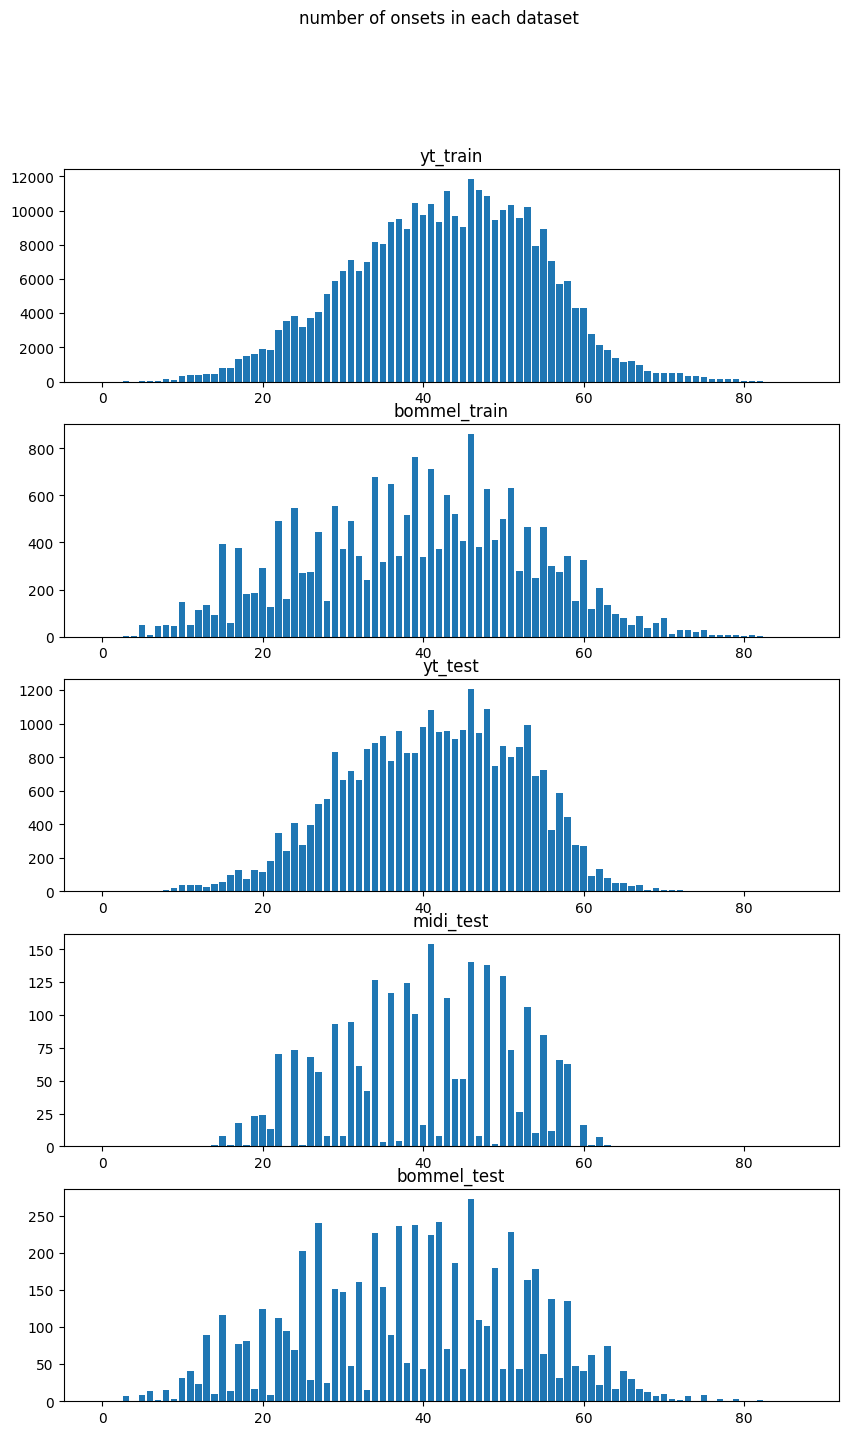

In [64]:
plt.figure(figsize=(10, 16))
plt.suptitle("number of onsets in each dataset")
for i, onset_sum in enumerate(onset_sum_list):
    plt.subplot(5, 1, i+1)
    plt.title(ds_names[i])
    plt.bar(range(88), np.sum(onset_sum, axis=0))

----------

### Get average note length

In [416]:
from collections import defaultdict

def get_note_length_stat(roll: np.array):
    label_np_t = label_np.T
    note_len_stat = defaultdict(int)
    for i in range(len(label_np_t)):
        note_len = 0
        for j in range(len(label_np_t[i])):
            if label_np_t[i][j] == 1:
                note_len += 1
            elif label_np_t[i][j] == 0 and note_len != 0:
                note_len_stat[note_len] += 1
                note_len = 0
    sorted_note_len = sorted(note_len_stat.items(), key=lambda x: x[0])
    return sorted_note_len

def draw_roll(roll: np.array):
    roll = roll.T[::-1]
    print(roll.shape)
    plt.imshow(roll[:, 0:500])

In [436]:
test_paths = sorted(glob("./data/bommelpiano/labels/training/*"))
note_len_mean = {}
plt.figure(figsize=(20, 20))
for i, test_path in enumerate(tqdm(test_paths)):
    filename = test_path.split("/")[-1]
    fileid = filename.split("_")[0]
    label_dict = np.load(test_path, allow_pickle=True)
    label_np = np.array(list(label_dict.values()))
    label_np = (label_np > 0).astype(int)
    
    note_len_stat = np.array(get_note_length_stat(label_np))
    note_len_mean[filename] = (np.sum(note_len_stat[:, 0] * note_len_stat[:, 1]) / sum(note_len_stat[:, 1]))
    
    # plt.title(fileid)
    # plt.subplot(4, 5, i+1)
    # plt.bar(note_len_stat[:, 0], note_len_stat[:, 1])

100% 30/30 [00:03<00:00,  7.83it/s]


<Figure size 2000x2000 with 0 Axes>

In [438]:
song_less_than_25 = []
for song_name, notelen in note_len_mean.items():
    if notelen <=25.0:
        song_less_than_25.append(song_name)

In [442]:
for song_name in song_less_than_25:
    # song_name = ".".join(song_name.split(".")[:-1])
    original_path = os.path.abspath(os.path.join("./data/bommelpiano/labels/training", song_name))
    target_path = os.path.abspath(os.path.join("./data/train_shortpedal/labels/training", song_name))
    os.system(f"ln -s '{original_path}' '{target_path}'")

-------------

### Get onset count

In [140]:
test_paths = sorted(glob("./data/bommelpiano/labels/testing/*"))
onset_count = []
for i, test_path in enumerate(tqdm(test_paths)):
    filename = test_path.split("/")[-1]
    fileid = filename.split("_")[0]
    label_dict = np.load(test_path, allow_pickle=True)
    label_np = np.array(list(label_dict.values()))
    label_np = (label_np > 0).astype(int)
    
    onset_np = make_onset(label_np)
    
    onset_count.append(np.sum(onset_np))

100% 9/9 [00:01<00:00,  4.90it/s]


In [141]:
onset_count

[362.0, 755.0, 482.0, 585.0, 805.0, 1147.0, 506.0, 584.0, 661.0]

-----------

### Get onset gap

In [122]:
def get_onset_gap(onset_roll: np.array):
    onset_gap_stat = defaultdict(int)
    one_line = np.sum(onset_roll, axis=1)
    gap_len = 0
    for onset in one_line:
        if onset > 0 and gap_len == 0:
            gap_len += 1
        elif onset > 0 and gap_len != 0:
            onset_gap_stat[gap_len] += 1
            gap_len = 1
        else:
            gap_len += 1
            
    sorted_onset_gap = sorted(onset_gap_stat.items(), key=lambda x: x[0])
    return sorted_onset_gap
            

  0% 0/9 [00:00<?, ?it/s]/tmp/ipykernel_10694/1028860501.py:18: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4, 5, i+1)
100% 9/9 [00:02<00:00,  3.59it/s]


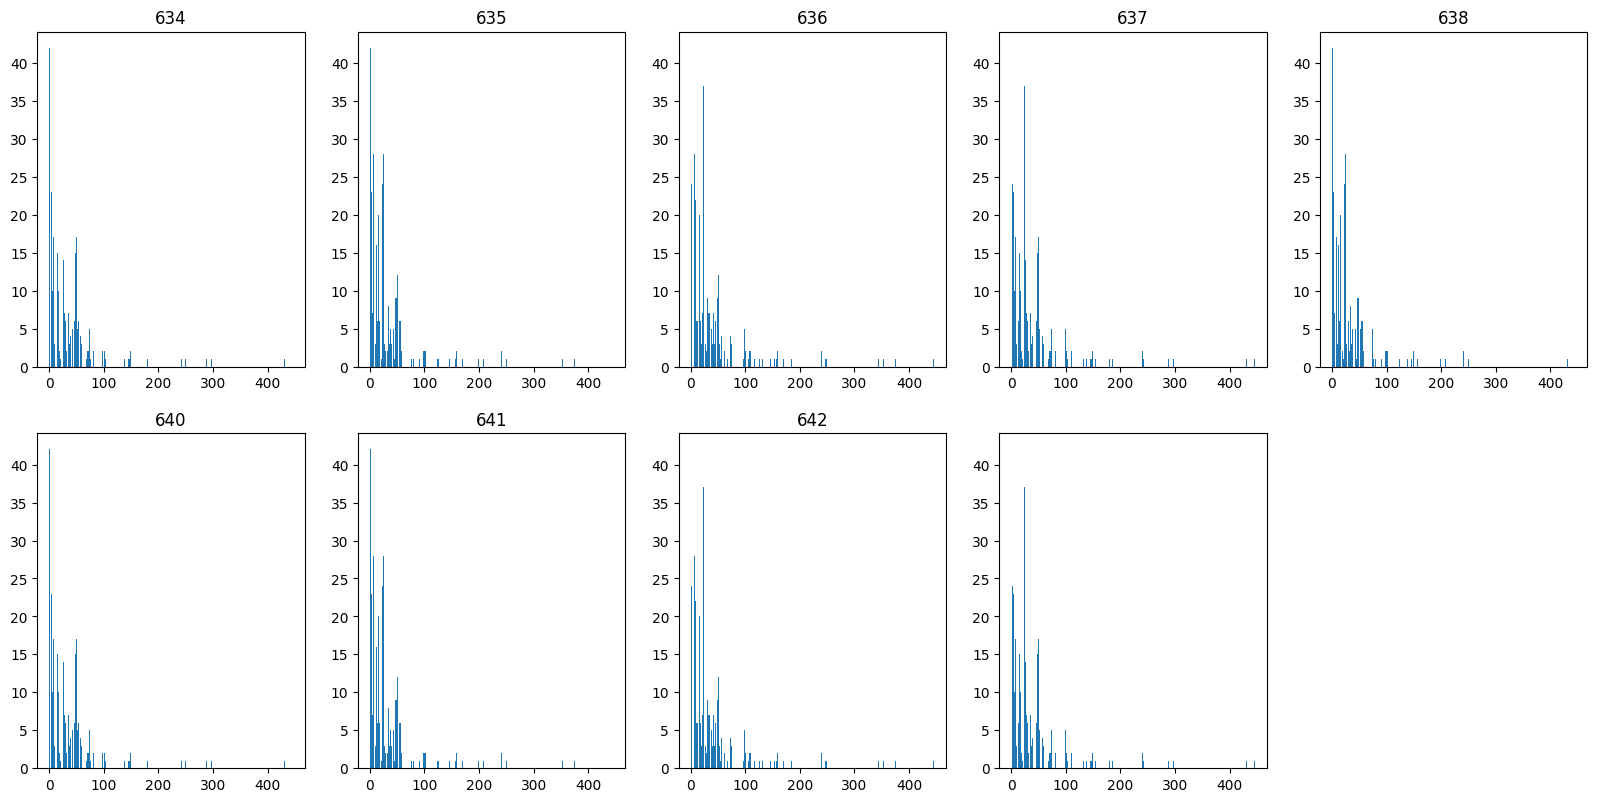

In [142]:
test_paths = sorted(glob("./data/bommelpiano/labels/testing/*"))
gap_mean = []
plt.figure(figsize=(20, 20))
for i, test_path in enumerate(tqdm(test_paths)):
    filename = test_path.split("/")[-1]
    fileid = filename.split("_")[0]
    label_dict = np.load(test_path, allow_pickle=True)
    label_np = np.array(list(label_dict.values()))
    label_np = (label_np > 0).astype(int)
    
    onset_np = make_onset(label_np)
    
    onset_gap = np.array(get_onset_gap(onset_np))
    
    gap_mean.append(np.sum(onset_gap[:, 0] * onset_gap[:, 1]) / sum(onset_gap[:, 1]))
    
    plt.title(fileid)
    plt.subplot(4, 5, i+1)
    plt.bar(note_len_stat[:, 0], note_len_stat[:, 1])

In [143]:
gap_mean

[10.738095238095237,
 7.948863636363637,
 5.358620689655172,
 6.403645833333333,
 6.036559139784946,
 6.9,
 12.250666666666667,
 7.78239608801956,
 9.533333333333333]

### Sampling one frame from videos

In [126]:
data_path = "./data/ytdataset/videos/test"
target_path_base = "./comp_images"
images_list = os.listdir(data_path)

In [127]:
sorted(images_list)

['600_Beethoven - Pathetique Sonata 1st Movement.mp4',
 '601_Mariage dAmour  wrongly known as Chopin - Spring Waltz.mp4',
 '602_Satie - Gnossienne No 1.mp4',
 '603_Mozart - Symphony No 40 1st Movement.mp4',
 '604_Tchaikovsky – March (The Nutcracker).mp4',
 '605_Mozart - Rondo Alla Turca (Turkish March) (Arr Yuja Wang).mp4',
 '606_Chopin - Waltz in E minor Op Posth.mp4',
 '607_Tchaikovsky - Valse Sentimentale.mp4',
 '608_Beethoven - Symphony No 7 II Allegretto.mp4',
 '609_Chopin - Etude Op 10 No 4 “Torrent”.mp4',
 '610_Ludovico Einaudi – Experience.mp4',
 '611_Beethoven - Moonlight Sonata 2nd Movement.mp4',
 '612_Chopin - Nocturne No 21 in C-Minor Op Posth.mp4',
 '613_Dvořák - From the New World (Symphony No 9 4th Movement).mp4',
 '614_Tchaikovsky - Dance of the Sugar Plum Fairy (The Nutcracker).mp4',
 '615_The Best Beautiful & Relaxing Piano Music.mp4',
 '616_Beethoven - Moonlight Sonata 1st Movement.mp4',
 '617_Saint-Saëns - Danse Macabre.mp4',
 '618_Mozart - Piano Concerto No 23 II A

In [128]:
for image_path_base in images_list:
    # image_path_base = sorted(images_list)[12]
    image_path = os.path.join(data_path, image_path_base)
    target_path = os.path.join(target_path_base, image_path_base)
    print(image_path)
    i=0
    cap = cv2.VideoCapture(image_path)
    while True:
        retval, frame = cap.read()
        if not(retval):	# 프레임정보를 정상적으로 읽지 못하면
            break  # while문을 빠져나가기
        i+=1
        # 키 입력을 받으면 키값을 key로 저장 -> esc == 27(아스키코드)
        if i == 1000:
            cv2.imwrite(f'{target_path_base}/{image_path_base}.png', frame)
            break	# while문을 빠져나가기

./data/kassia/videos/train/650_Tchaikovsky – Swan Lake.mp4
./data/kassia/videos/train/645_SchubertLiszt - Ave Maria.mp4
./data/kassia/videos/train/633_Fly Me to the Moon.mp4
./data/kassia/videos/train/637_Chopin - Nocturne Op9 No2 (E Flat Major).mp4
./data/kassia/videos/train/660_Chopin – Fantaisie-Impromptu Op 66.mp4
./data/kassia/videos/train/628_Beethoven - Symphony No 5.mp4
./data/kassia/videos/train/662_Grieg – In the Hall of the Mountain King.mp4
./data/kassia/videos/train/624_Handel – Sarabande.mp4
./data/kassia/videos/train/682_GlinkaBalakirev – The Lark.mp4
./data/kassia/videos/train/611_Beethoven - Moonlight Sonata 2nd Movement.mp4
./data/kassia/videos/train/640_Chopin – Waltz Op 64 No 2.mp4
./data/kassia/videos/train/601_Mariage dAmour  wrongly known as Chopin - Spring Waltz.mp4
./data/kassia/videos/train/602_Satie - Gnossienne No 1.mp4
./data/kassia/videos/train/608_Beethoven - Symphony No 7 II Allegretto.mp4
./data/kassia/videos/train/604_Tchaikovsky – March (The Nutcracke

----------

### analog crop

In [145]:
from keyboard_det.crop_preprocess import crop_piano

In [146]:
from glob import glob
import cv2
import matplotlib.pyplot as plt

In [147]:
img_list = sorted(glob("./comp_images/*"))

In [148]:
img_iter = iter(img_list)


0: 384x640 1 piano, 6.9ms
Speed: 1.4ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)


./comp_images/604_Tchaikovsky – March (The Nutcracker).mp4.png
(720, 1280, 3)
tensor([0.9250], device='cuda:0')
minY: 365, maxY: 533, minX: 1, maxX: 1280


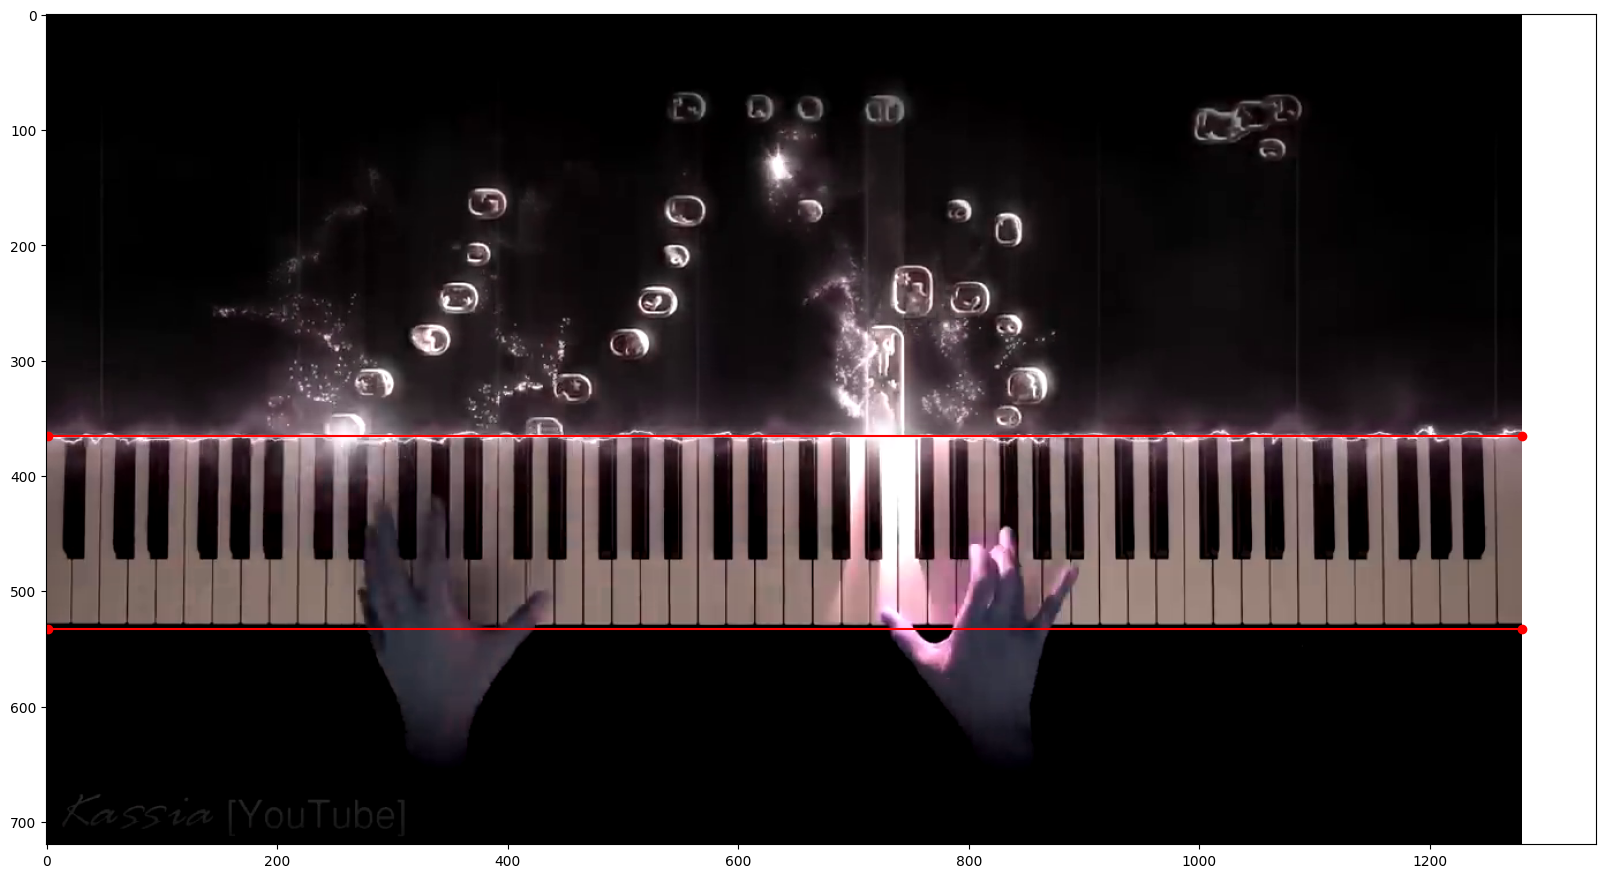

In [153]:
plt.figure(figsize=(20, 15))


img = next(img_iter)
# img = img_list[12]

print(img)
img = cv2.imread(img)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(img.shape)
points = crop_piano(img)
print("minY: {1}, maxY: {3}, minX: {0}, maxX: {2}".format(*points))
plt.imshow(img)
plt.scatter([points[0], points[0], points[2], points[2]], [points[1], points[3], points[1], points[3]], color="red")
plt.plot([points[0], points[2]], [points[1], points[1]], color="red")
plt.plot([points[0], points[2]], [points[3], points[3]], color="red")

maxYoffset 879


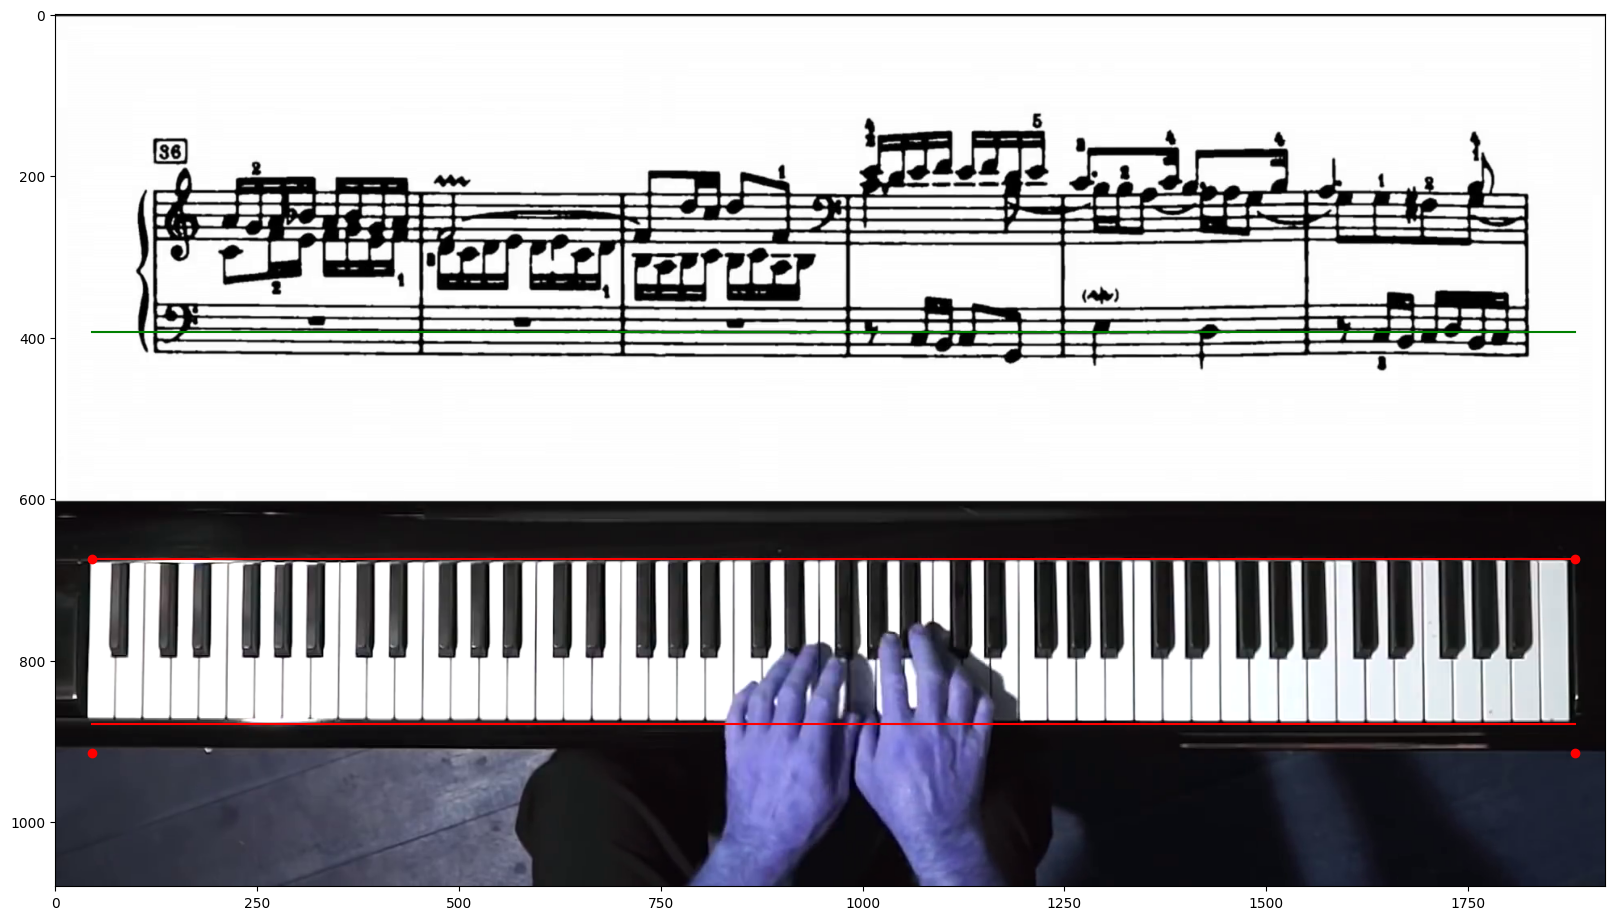

In [41]:
offset = 36
print(f"maxYoffset {points[3]-offset}")
testminY = 393
plt.figure(figsize=(20, 15))
plt.imshow(img)
plt.scatter([points[0], points[0], points[2], points[2]], [points[1], points[3], points[1], points[3]], color="red")
plt.plot([points[0], points[2]], [points[1], points[1]], color="red")
plt.plot([points[0], points[2]], [testminY, testminY], color="green")
plt.plot([points[0], points[2]], [points[3]-offset, points[3]-offset], color="red")

In [157]:
import pandas as pd

In [162]:
csv = pd.read_csv("./data/PianoYT/yt_kassia.csv", names=["id", "link", "train/val", "ymin", "ymax", "xmin", "xmax"])

In [178]:
for img in tqdm(img_list):
    img_id = img.split("/")[-1].split("_")[0]
    img = cv2.imread(img)
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    points = crop_piano(img)
    # print("minY: {1}, maxY: {3}, minX: {0}, maxX: {2}".format(*points))
    minY, maxY = points[1], points[3]
    csv.loc[csv['id'] == int(img_id), 'ymin'] = minY
    csv.loc[csv['id'] == int(img_id), 'ymax'] = maxY

  0% 0/96 [00:00<?, ?it/s]
0: 384x640 1 piano, 6.9ms
Speed: 1.3ms preprocess, 6.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
  1% 1/96 [00:00<00:14,  6.53it/s]
0: 384x640 1 piano, 6.7ms
Speed: 1.3ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
  2% 2/96 [00:00<00:11,  7.83it/s]


tensor([0.9293], device='cuda:0')
tensor([0.9252], device='cuda:0')


0: 384x640 1 piano, 14.0ms
Speed: 2.9ms preprocess, 14.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)
  3% 3/96 [00:00<00:12,  7.58it/s]
0: 384x640 1 piano, 6.5ms
Speed: 1.2ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
  4% 4/96 [00:00<00:12,  7.47it/s]

tensor([0.9229], device='cuda:0')
tensor([0.9258], device='cuda:0')



0: 384x640 1 piano, 6.6ms
Speed: 1.3ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
  5% 5/96 [00:00<00:11,  7.99it/s]
0: 384x640 1 piano, 12.8ms
Speed: 2.1ms preprocess, 12.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)
  6% 6/96 [00:00<00:11,  7.87it/s]

tensor([0.9250], device='cuda:0')
tensor([0.9206], device='cuda:0')



0: 384x640 1 piano, 7.0ms
Speed: 1.4ms preprocess, 7.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)
  7% 7/96 [00:00<00:10,  8.11it/s]
0: 384x640 1 piano, 6.6ms
Speed: 1.3ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
  8% 8/96 [00:01<00:10,  8.39it/s]


tensor([0.9275], device='cuda:0')
tensor([0.9250], device='cuda:0')


0: 384x640 1 piano, 6.6ms
Speed: 1.3ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
  9% 9/96 [00:01<00:10,  8.61it/s]
0: 384x640 1 piano, 6.5ms
Speed: 1.3ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 10% 10/96 [00:01<00:09,  8.76it/s]


tensor([0.9289], device='cuda:0')
tensor([0.9246], device='cuda:0')


0: 384x640 1 piano, 6.6ms
Speed: 1.3ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 11% 11/96 [00:01<00:09,  8.83it/s]
0: 384x640 1 piano, 7.0ms
Speed: 1.4ms preprocess, 7.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)
 12% 12/96 [00:01<00:09,  8.51it/s]

tensor([0.9296], device='cuda:0')
tensor([0.9188], device='cuda:0')



0: 384x640 1 piano, 6.7ms
Speed: 1.3ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)
 14% 13/96 [00:01<00:09,  8.62it/s]
0: 384x640 1 piano, 6.6ms
Speed: 1.3ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 15% 14/96 [00:01<00:09,  8.75it/s]


tensor([0.9266], device='cuda:0')
tensor([0.9270], device='cuda:0')


0: 384x640 1 piano, 6.6ms
Speed: 1.3ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 16% 15/96 [00:01<00:09,  8.86it/s]
0: 384x640 1 piano, 6.5ms
Speed: 1.2ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 17% 16/96 [00:01<00:08,  8.95it/s]


tensor([0.9267], device='cuda:0')
tensor([0.9236], device='cuda:0')


0: 384x640 1 piano, 6.7ms
Speed: 1.3ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 18% 17/96 [00:02<00:08,  8.99it/s]
0: 384x640 1 piano, 6.7ms
Speed: 1.3ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)
 19% 18/96 [00:02<00:08,  8.93it/s]

tensor([0.9308], device='cuda:0')
tensor([0.9332], device='cuda:0')



0: 384x640 1 piano, 6.6ms
Speed: 1.2ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 20% 19/96 [00:02<00:08,  8.96it/s]
0: 384x640 1 piano, 6.8ms
Speed: 1.3ms preprocess, 6.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 21% 20/96 [00:02<00:08,  9.01it/s]


tensor([0.9277], device='cuda:0')
tensor([0.9304], device='cuda:0')


0: 384x640 1 piano, 11.1ms
Speed: 2.0ms preprocess, 11.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)
 22% 21/96 [00:02<00:08,  8.54it/s]
0: 384x640 1 piano, 7.0ms
Speed: 1.5ms preprocess, 7.0ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)
 23% 22/96 [00:02<00:09,  7.69it/s]

tensor([0.9277], device='cuda:0')
tensor([0.9325], device='cuda:0')



0: 384x640 1 piano, 8.9ms
Speed: 1.6ms preprocess, 8.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
 24% 23/96 [00:03<00:16,  4.46it/s]
0: 384x640 1 piano, 6.8ms
Speed: 1.2ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)
 25% 24/96 [00:03<00:13,  5.26it/s]

tensor([0.9289], device='cuda:0')
tensor([0.9269], device='cuda:0')



0: 384x640 1 piano, 6.6ms
Speed: 1.3ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 26% 25/96 [00:03<00:11,  5.97it/s]
0: 384x640 1 piano, 6.5ms
Speed: 1.2ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 27% 26/96 [00:03<00:10,  6.37it/s]

tensor([0.9294], device='cuda:0')
tensor([0.9234], device='cuda:0')



0: 384x640 1 piano, 6.6ms
Speed: 1.2ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 28% 27/96 [00:03<00:09,  6.98it/s]
0: 384x640 1 piano, 6.7ms
Speed: 1.2ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 29% 28/96 [00:03<00:09,  7.13it/s]

tensor([0.9315], device='cuda:0')
tensor([0.9242], device='cuda:0')



0: 384x640 1 piano, 6.9ms
Speed: 1.3ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)
 30% 29/96 [00:03<00:09,  7.24it/s]
0: 384x640 1 piano, 6.8ms
Speed: 1.3ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)
 31% 30/96 [00:03<00:08,  7.36it/s]

tensor([0.9229], device='cuda:0')
tensor([0.9163], device='cuda:0')



0: 384x640 1 piano, 6.6ms
Speed: 1.2ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 32% 31/96 [00:04<00:08,  7.80it/s]
0: 384x640 1 piano, 6.6ms
Speed: 1.3ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 33% 32/96 [00:04<00:07,  8.15it/s]


tensor([0.9224], device='cuda:0')
tensor([0.9289], device='cuda:0')


0: 384x640 1 piano, 6.7ms
Speed: 1.2ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 34% 33/96 [00:04<00:07,  8.39it/s]
0: 384x640 1 piano, 6.8ms
Speed: 1.2ms preprocess, 6.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 35% 34/96 [00:04<00:07,  8.50it/s]

tensor([0.9193], device='cuda:0')
tensor([0.9234], device='cuda:0')



0: 384x640 1 piano, 6.7ms
Speed: 1.2ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 36% 35/96 [00:04<00:07,  8.54it/s]
0: 384x640 1 piano, 6.7ms
Speed: 1.2ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 38% 36/96 [00:04<00:07,  8.37it/s]

tensor([0.9283], device='cuda:0')
tensor([0.9271], device='cuda:0')



0: 384x640 1 piano, 6.9ms
Speed: 1.3ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)
 39% 37/96 [00:04<00:07,  8.13it/s]
0: 384x640 1 piano, 6.6ms
Speed: 1.3ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 40% 38/96 [00:04<00:07,  8.03it/s]

tensor([0.9185], device='cuda:0')
tensor([0.9316], device='cuda:0')



0: 384x640 1 piano, 6.9ms
Speed: 1.4ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)
 41% 39/96 [00:05<00:06,  8.25it/s]
0: 384x640 1 piano, 6.6ms
Speed: 1.3ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 42% 40/96 [00:05<00:07,  7.99it/s]

tensor([0.9265], device='cuda:0')
tensor([0.9009], device='cuda:0')



0: 384x640 1 piano, 9.9ms
Speed: 1.9ms preprocess, 9.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)
 43% 41/96 [00:05<00:07,  7.64it/s]
0: 384x640 1 piano, 6.6ms
Speed: 1.2ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 44% 42/96 [00:05<00:06,  7.99it/s]

tensor([0.9270], device='cuda:0')
tensor([0.9247], device='cuda:0')



0: 384x640 1 piano, 6.6ms
Speed: 1.2ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 45% 43/96 [00:05<00:06,  8.29it/s]
0: 384x640 1 piano, 10.6ms
Speed: 1.9ms preprocess, 10.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)
 46% 44/96 [00:05<00:06,  8.15it/s]

tensor([0.9255], device='cuda:0')
tensor([0.9237], device='cuda:0')



0: 384x640 1 piano, 6.6ms
Speed: 1.2ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 47% 45/96 [00:05<00:06,  8.38it/s]
0: 384x640 1 piano, 6.6ms
Speed: 1.2ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 48% 46/96 [00:05<00:05,  8.59it/s]


tensor([0.9256], device='cuda:0')
tensor([0.9273], device='cuda:0')


0: 384x640 1 piano, 11.6ms
Speed: 1.6ms preprocess, 11.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)
 49% 47/96 [00:05<00:05,  8.31it/s]
0: 384x640 1 piano, 6.6ms
Speed: 1.2ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)
 50% 48/96 [00:06<00:05,  8.49it/s]

tensor([0.9299], device='cuda:0')
tensor([0.9297], device='cuda:0')



0: 384x640 1 piano, 6.8ms
Speed: 1.3ms preprocess, 6.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 51% 49/96 [00:06<00:05,  8.22it/s]
0: 384x640 1 piano, 11.3ms
Speed: 1.8ms preprocess, 11.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)
 52% 50/96 [00:06<00:05,  8.08it/s]

tensor([0.9302], device='cuda:0')
tensor([0.9273], device='cuda:0')



0: 384x640 1 piano, 6.6ms
Speed: 1.2ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 53% 51/96 [00:06<00:05,  8.30it/s]
0: 384x640 1 piano, 10.2ms
Speed: 1.9ms preprocess, 10.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)
 54% 52/96 [00:06<00:05,  7.92it/s]

tensor([0.9292], device='cuda:0')
tensor([0.9275], device='cuda:0')



0: 384x640 1 piano, 6.8ms
Speed: 1.4ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)
 55% 53/96 [00:06<00:05,  7.81it/s]
0: 384x640 1 piano, 6.7ms
Speed: 1.3ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)
 56% 54/96 [00:06<00:05,  8.09it/s]

tensor([0.9276], device='cuda:0')
tensor([0.9306], device='cuda:0')



0: 384x640 1 piano, 10.0ms
Speed: 1.8ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
 57% 55/96 [00:06<00:05,  7.95it/s]
0: 384x640 1 piano, 6.6ms
Speed: 1.2ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 58% 56/96 [00:07<00:05,  7.93it/s]

tensor([0.9298], device='cuda:0')
tensor([0.9291], device='cuda:0')



0: 384x640 1 piano, 6.6ms
Speed: 1.2ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 59% 57/96 [00:07<00:04,  8.19it/s]
0: 384x640 1 piano, 13.2ms
Speed: 3.0ms preprocess, 13.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)
 60% 58/96 [00:07<00:04,  7.69it/s]

tensor([0.9282], device='cuda:0')
tensor([0.9330], device='cuda:0')



0: 384x640 1 piano, 6.5ms
Speed: 1.2ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 61% 59/96 [00:07<00:04,  7.64it/s]
0: 384x640 1 piano, 6.6ms
Speed: 1.3ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)
 62% 60/96 [00:07<00:04,  8.07it/s]


tensor([0.9280], device='cuda:0')
tensor([0.9278], device='cuda:0')


0: 384x640 1 piano, 6.6ms
Speed: 1.3ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 64% 61/96 [00:07<00:04,  8.33it/s]
0: 384x640 1 piano, 6.6ms
Speed: 1.2ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 65% 62/96 [00:07<00:03,  8.53it/s]


tensor([0.9288], device='cuda:0')
tensor([0.9274], device='cuda:0')


0: 384x640 1 piano, 6.9ms
Speed: 1.4ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)
 66% 63/96 [00:07<00:03,  8.70it/s]
0: 384x640 1 piano, 6.6ms
Speed: 1.3ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 67% 64/96 [00:08<00:03,  8.78it/s]


tensor([0.9272], device='cuda:0')
tensor([0.9320], device='cuda:0')


0: 384x640 1 piano, 6.7ms
Speed: 1.3ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 68% 65/96 [00:08<00:03,  8.90it/s]
0: 384x640 1 piano, 6.5ms
Speed: 1.2ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 69% 66/96 [00:08<00:03,  8.93it/s]

tensor([0.9268], device='cuda:0')
tensor([0.9266], device='cuda:0')



0: 384x640 1 piano, 6.6ms
Speed: 1.3ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 70% 67/96 [00:08<00:03,  8.56it/s]
0: 384x640 1 piano, 6.8ms
Speed: 1.3ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)
 71% 68/96 [00:08<00:03,  8.66it/s]

tensor([0.9262], device='cuda:0')
tensor([0.9261], device='cuda:0')



0: 384x640 1 piano, 6.6ms
Speed: 1.3ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 72% 69/96 [00:08<00:03,  8.39it/s]
0: 384x640 1 piano, 6.7ms
Speed: 1.3ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 73% 70/96 [00:08<00:03,  8.63it/s]

tensor([0.9287], device='cuda:0')
tensor([0.9217], device='cuda:0')



0: 384x640 1 piano, 6.7ms
Speed: 1.3ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 74% 71/96 [00:08<00:02,  8.35it/s]
0: 384x640 1 piano, 8.7ms
Speed: 1.8ms preprocess, 8.7ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)
 75% 72/96 [00:09<00:02,  8.31it/s]

tensor([0.9284], device='cuda:0')
tensor([0.9220], device='cuda:0')



0: 384x640 1 piano, 9.7ms
Speed: 1.6ms preprocess, 9.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)
 76% 73/96 [00:09<00:02,  8.17it/s]
0: 384x640 1 piano, 6.7ms
Speed: 1.2ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 77% 74/96 [00:09<00:02,  8.34it/s]

tensor([0.9276], device='cuda:0')
tensor([0.9288], device='cuda:0')



0: 384x640 1 piano, 6.7ms
Speed: 1.3ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 78% 75/96 [00:09<00:02,  8.52it/s]
0: 384x640 1 piano, 6.6ms
Speed: 1.3ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 79% 76/96 [00:09<00:02,  8.27it/s]

tensor([0.9212], device='cuda:0')
tensor([0.9140], device='cuda:0')



0: 384x640 1 piano, 8.7ms
Speed: 2.2ms preprocess, 8.7ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)
 80% 77/96 [00:09<00:02,  8.26it/s]
0: 384x640 1 piano, 6.9ms
Speed: 1.4ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)
 81% 78/96 [00:09<00:02,  8.48it/s]

tensor([0.9304], device='cuda:0')
tensor([0.9308], device='cuda:0')



0: 384x640 1 piano, 13.5ms
Speed: 2.9ms preprocess, 13.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)
 82% 79/96 [00:09<00:02,  8.15it/s]
0: 384x640 1 piano, 6.6ms
Speed: 1.3ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 83% 80/96 [00:09<00:01,  8.41it/s]


tensor([0.9290], device='cuda:0')
tensor([0.9267], device='cuda:0')


0: 384x640 1 piano, 6.6ms
Speed: 1.3ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 84% 81/96 [00:10<00:01,  8.58it/s]
0: 384x640 1 piano, 6.6ms
Speed: 1.3ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)
 85% 82/96 [00:10<00:01,  8.73it/s]


tensor([0.9296], device='cuda:0')
tensor([0.9241], device='cuda:0')


0: 384x640 1 piano, 12.1ms
Speed: 2.9ms preprocess, 12.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)
 86% 83/96 [00:10<00:01,  8.39it/s]
0: 384x640 1 piano, 6.6ms
Speed: 1.3ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 88% 84/96 [00:10<00:01,  8.54it/s]

tensor([0.9320], device='cuda:0')
tensor([0.9283], device='cuda:0')



0: 384x640 1 piano, 6.7ms
Speed: 1.3ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 89% 85/96 [00:10<00:01,  8.68it/s]
0: 384x640 1 piano, 6.7ms
Speed: 1.3ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 90% 86/96 [00:10<00:01,  8.81it/s]


tensor([0.9255], device='cuda:0')
tensor([0.9327], device='cuda:0')


0: 384x640 1 piano, 6.7ms
Speed: 1.3ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 91% 87/96 [00:10<00:01,  8.92it/s]
0: 384x640 1 piano, 6.8ms
Speed: 1.3ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)
 92% 88/96 [00:10<00:00,  8.93it/s]

tensor([0.9263], device='cuda:0')
tensor([0.9299], device='cuda:0')



0: 384x640 1 piano, 6.8ms
Speed: 1.3ms preprocess, 6.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 93% 89/96 [00:10<00:00,  8.66it/s]
0: 384x640 1 piano, 6.6ms
Speed: 1.3ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 94% 90/96 [00:11<00:00,  8.39it/s]

tensor([0.9257], device='cuda:0')
tensor([0.9280], device='cuda:0')



0: 384x640 1 piano, 6.6ms
Speed: 1.3ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 95% 91/96 [00:11<00:00,  8.58it/s]
0: 384x640 1 piano, 6.7ms
Speed: 1.3ms preprocess, 6.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 96% 92/96 [00:11<00:00,  8.78it/s]


tensor([0.9137], device='cuda:0')
tensor([0.9127], device='cuda:0')


0: 384x640 1 piano, 6.8ms
Speed: 1.3ms preprocess, 6.8ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 97% 93/96 [00:11<00:00,  8.89it/s]
0: 384x640 1 piano, 10.1ms
Speed: 1.7ms preprocess, 10.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)
 98% 94/96 [00:11<00:00,  8.07it/s]

tensor([0.9282], device='cuda:0')
tensor([0.9265], device='cuda:0')



0: 384x640 1 piano, 6.6ms
Speed: 1.3ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
 99% 95/96 [00:11<00:00,  7.99it/s]
0: 384x640 1 piano, 6.5ms
Speed: 1.3ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)
100% 96/96 [00:11<00:00,  8.11it/s]

tensor([0.9288], device='cuda:0')
tensor([0.9315], device='cuda:0')


In [181]:
csv['xmax'] = [1280]*96

In [184]:
csv.to_csv("./data/PianoYT/yt_kassia.csv", header=False, index=False)

-------

### image samples

In [134]:
# image_paths = glob("./data/bommelpiano/images/training/*")
image_paths = glob("./data/ytdataset/images_nopad/testing/*")

In [135]:
image_paths

['./data/ytdataset/images_nopad/testing/116_“Méditation de Thaïs” Massenet PIANO SOLO + FREE SHEET MUSIC.mp4',
 './data/ytdataset/images_nopad/testing/303_Bach 2 Part Invention No9 - P Barton FEURICH Harmonic Pedal piano.mp4',
 './data/ytdataset/images_nopad/testing/165_Mahler Adagietto Symphony No5 - PIANO + FREE sheet music.mp4',
 './data/ytdataset/images_nopad/testing/161_Bach Prelude and Fugue No4 (take 2) Well Tempered Clavier Book 2 with Harmonic PedalHP piano.mp4',
 './data/ytdataset/images_nopad/testing/130_Bach “Air on the G String” (arr Siloti) Paul Barton FEURICH piano.mp4',
 './data/ytdataset/images_nopad/testing/166_César Franck PIANO + FREE sheet music -  Paul Barton FEURICH piano.mp4',
 './data/ytdataset/images_nopad/testing/302_Chopin Fantaisie-Impromptu Op66 P Barton FEURICH piano.mp4',
 './data/ytdataset/images_nopad/testing/307_Debussy Arabesque No2 - P Barton FEURICH 218 harmonic pedal piano.mp4',
 './data/ytdataset/images_nopad/testing/162_Bach Prelude and Fugue N

In [137]:
for i, image_path in enumerate(image_paths):
    img_id = image_path.split('/')[-1].split('_')[0]
    target_load_path = os.path.join(image_path, f'2000.png')
    target_save_path = os.path.join("./comp_images2", f'{img_id}_2000.png')
    os.system(f"cp '{target_load_path}' '{target_save_path}'")

----------

In [446]:
from model import Video2RollNet
import torch
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import glob

In [447]:
model_checkpoint = "./experiments/46_2023-07-16 11:15:27_best_baseline2/Video2Roll_bestf1.pth"
song_name = "168_Bach Prelude and Fugue No2 Well Tempered Clavier Book 2 with Harmonic Pedal.mp4"
image_path = os.path.join("./data/ytdataset/images_nopad/testing", song_name)
label_path = os.path.join("./data/ytdataset/labels_audeo/testing", song_name) + ".pkl"

In [448]:
image_count = len(os.listdir(image_path))

In [449]:
model = Video2RollNet(num_classes=85)
model.to("cuda:1")
model.load_state_dict(torch.load(model_checkpoint, map_location="cuda:1"))

<All keys matched successfully>

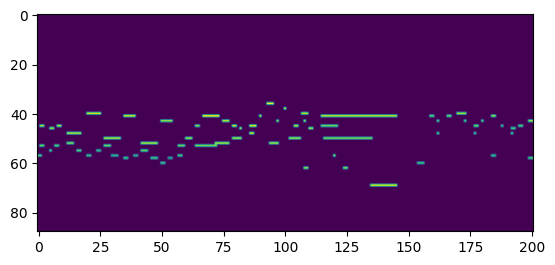

In [450]:
label_dict = np.load(label_path, allow_pickle=True)
label_np = np.stack(label_dict.values())
label_np = label_np.T[::-1]

plt.imshow(label_np[:, 800:1001])

In [451]:
full_img_list = []
for i in range(2, image_count-2):
    image_name_list = [str(i).zfill(4) + ".png" for i in range(i-1, i+4)]
    full_img_list.append(image_name_list)

In [452]:
full_img_list[-1]

['7594.png', '7595.png', '7596.png', '7597.png', '7598.png']

In [453]:
import time

In [454]:
time.time()

1689609114.6362207

In [455]:
img_loading_time = 0
img_postprocess_time = 0
img_inference_time = 0

In [456]:
logit_list = []
model.eval()
with torch.no_grad():
    batch = []
    for i, img_list in enumerate(tqdm(full_img_list)):
        img_stack = []
        c = time.time()
        for img in img_list:
            img_path = os.path.join(image_path, img)
            pil_img = Image.open(img_path).convert('L')
            img_stack.append(np.array(pil_img) / 255.)
        img_loading_time += time.time() - c
        
        c = time.time()
        img_stack = torch.from_numpy(np.stack(img_stack)).unsqueeze(dim=0).float()
        batch.append(img_stack)
        img_postprocess_time += time.time() - c

        if len(batch)==50 or i==len(full_img_list)-1:
            c = time.time()
            batch = torch.cat(batch)
            output_test = model(batch.to("cuda:1"))
            output_logit = torch.sigmoid(output_test)
            logit_list.append(output_logit)
            batch = []
            img_inference_time += time.time() - c


# logit_list = []
# model.eval()
# with torch.no_grad():
#     batch = []
#     for i, img_list in enumerate(tqdm(sorted(glob.glob(image_path + "/*"), key=lambda x: int(x.split("/")[-1].split(".")[0])))):
#         img_stack = []

#         c = time.time()
#         while len(img_stack) != 5:
#             pil_img = Image.open(img_list).convert('L')
#             img_stack.append(np.array(pil_img) / 255.)
#         img_loading_time += time.time() - c
        
#         c = time.time()
#         img_stack = torch.from_numpy(np.stack(img_stack)).unsqueeze(dim=0).float()
#         batch.append(img_stack)
#         img_stack = img_stack[1:]
#         img_postprocess_time += time.time() - c
        
#         if len(batch)==50 or i==len(full_img_list)-1:
#             c = time.time()
#             batch = torch.cat(batch)
#             output_test = model(batch.to("cuda:1"))
#             output_logit = torch.sigmoid(output_test)
#             logit_list.append(output_logit)
#             batch = []
#             img_inference_time += time.time() - c
            
            

100% 7594/7594 [01:06<00:00, 115.06it/s]


In [458]:
print(img_loading_time, img_postprocess_time, img_inference_time)

54.89968991279602 5.760353088378906 4.78582239151001


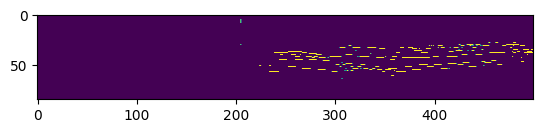

In [459]:
logit_output = torch.cat(logit_list).squeeze().detach().cpu().numpy()
logit_output = logit_output.T[::-1]
plt.imshow(logit_output[:, 0:500]>0.4)

In [465]:
inference_out = "./outputs_exp46/v2r_output/168_Bach Prelude and Fugue No2 Well Tempered Clavier Book 2 with Harmonic Pedal.mp4"

In [466]:
inference_list = glob.glob(inference_out + "/*")
inference_list = sorted(inference_list, key=lambda x: int(x.split("/")[-1].split("-")[0]))

In [467]:
inf_list = []
inf_logit = []
for inf in inference_list:
    inf_load = np.load(inf, allow_pickle=True)
    inf_list.append(inf_load['roll'])
    inf_logit.append(inf_load['logit'])
inf_list = np.concatenate(inf_list)
inf_logit = np.concatenate(inf_logit)

In [468]:
inf_list.shape

(7550, 88)

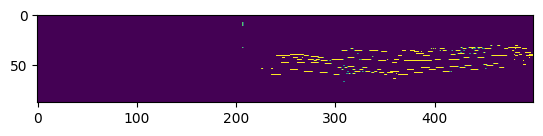

In [469]:
plt.imshow(inf_list.T[::-1][:, 0:500])

In [470]:
roll_output = np.pad((logit_output >= 0.4), ((3, 0), (2, 2)))

In [471]:
label_np = (label_np>0.0).astype(int)
roll_output = roll_output.astype(int)

In [567]:
class F1Loss:
    def __init__(self):
        pass
    
    def __call__(self, pred, target):
        eps = 1e-8
        label_np_T = target.T
        roll_output_T = pred.T
        print(label_np_T.shape)

        tp = torch.sum(label_np_T*roll_output_T, axis=0)
        tn = torch.sum((1-label_np_T)*(1-roll_output_T), axis=0)
        fp = torch.sum((1-label_np_T)*roll_output_T, axis=0)
        fn = torch.sum(label_np_T*(1-roll_output_T), axis=0)

        p = tp / (tp + fp)
        r = tp / (tp + fn)

        f1 = 2*p*r / (p+r+eps)
        f1 = torch.nansum(f1) / torch.sum(~torch.isnan(f1))
        return f1

In [568]:
A = torch.cat([torch.tensor(roll_output).unsqueeze(dim=0), torch.tensor(roll_output).unsqueeze(dim=0)])
B = torch.cat([torch.tensor(label_np).unsqueeze(dim=0), torch.tensor(label_np).unsqueeze(dim=0)])

In [580]:
torch.tensor(roll_output).unsqueeze(dim=0).shape

torch.Size([1, 88, 7598])

In [576]:
C = torch.tensor([1,1,0,1,0])

In [577]:
import torch.nn.functional as F

In [579]:
F.one_hot(C, 2).shape

torch.Size([5, 2])

In [566]:
F1Loss()(A, B)

torch.Size([7598, 88, 2])


tensor(0.5979)

In [543]:
torch.tensor(roll_output).unsqueeze(dim=0).shape

torch.Size([1, 88, 7598])

In [491]:
same = []
diff = []
for i, (roll_line, label_line) in enumerate(zip(roll_output.T, label_np.T)):
    if np.array_equal(roll_line, label_line):
        same.append(i)
    else:
        diff.append(i)

In [492]:
len(same)

2182

In [493]:
len(diff)

5416

In [504]:
idx = np.random.choice(diff, 1)[0]
print(idx)

3071


In [505]:
def note_convert_to_char(notes):
    NOTE = ["A", "A#", "B", "C", "C#", "D", "D#", "E", "F", "F#", "G", "G#"]
    
    return [NOTE[note%12] + str(((note+9) // 12) + 1) for note in notes]

In [506]:
label_notes = np.where(label_np[:, idx:idx+1].T[0][::-1] == 1)[0]
pred_notes = np.where(roll_output[:, idx:idx+1].T[0][::-1] == 1)[0]

In [507]:
label_notes_h = note_convert_to_char(label_notes)
pred_notes_h = note_convert_to_char(pred_notes)

In [508]:
label_notes_h

[]

In [509]:
pred_notes_h

['G4', 'D#5']

In [510]:
full_img_list[idx-2]

['3070.png', '3071.png', '3072.png', '3073.png', '3074.png']

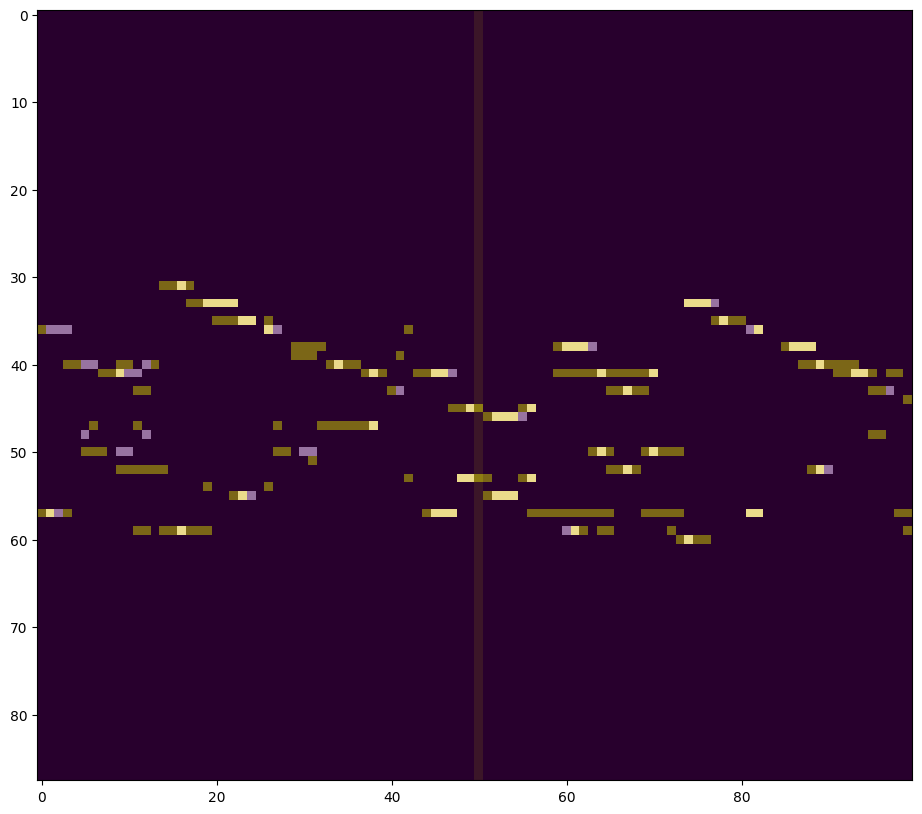

In [511]:
mid_line = np.zeros((88, 100))
mid_line[:, 50] = np.ones(88,)
plt.figure(figsize=(20, 10))
plt.imshow(label_np[:, idx-50:idx+50], cmap="hot")
plt.imshow(roll_output[:, idx-50:idx+50], alpha=0.5)
plt.imshow(mid_line, alpha=0.1)

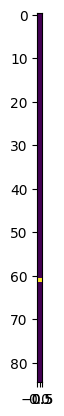

In [415]:
plt.imshow(logit_output[:, idx:idx+1]>0.5)

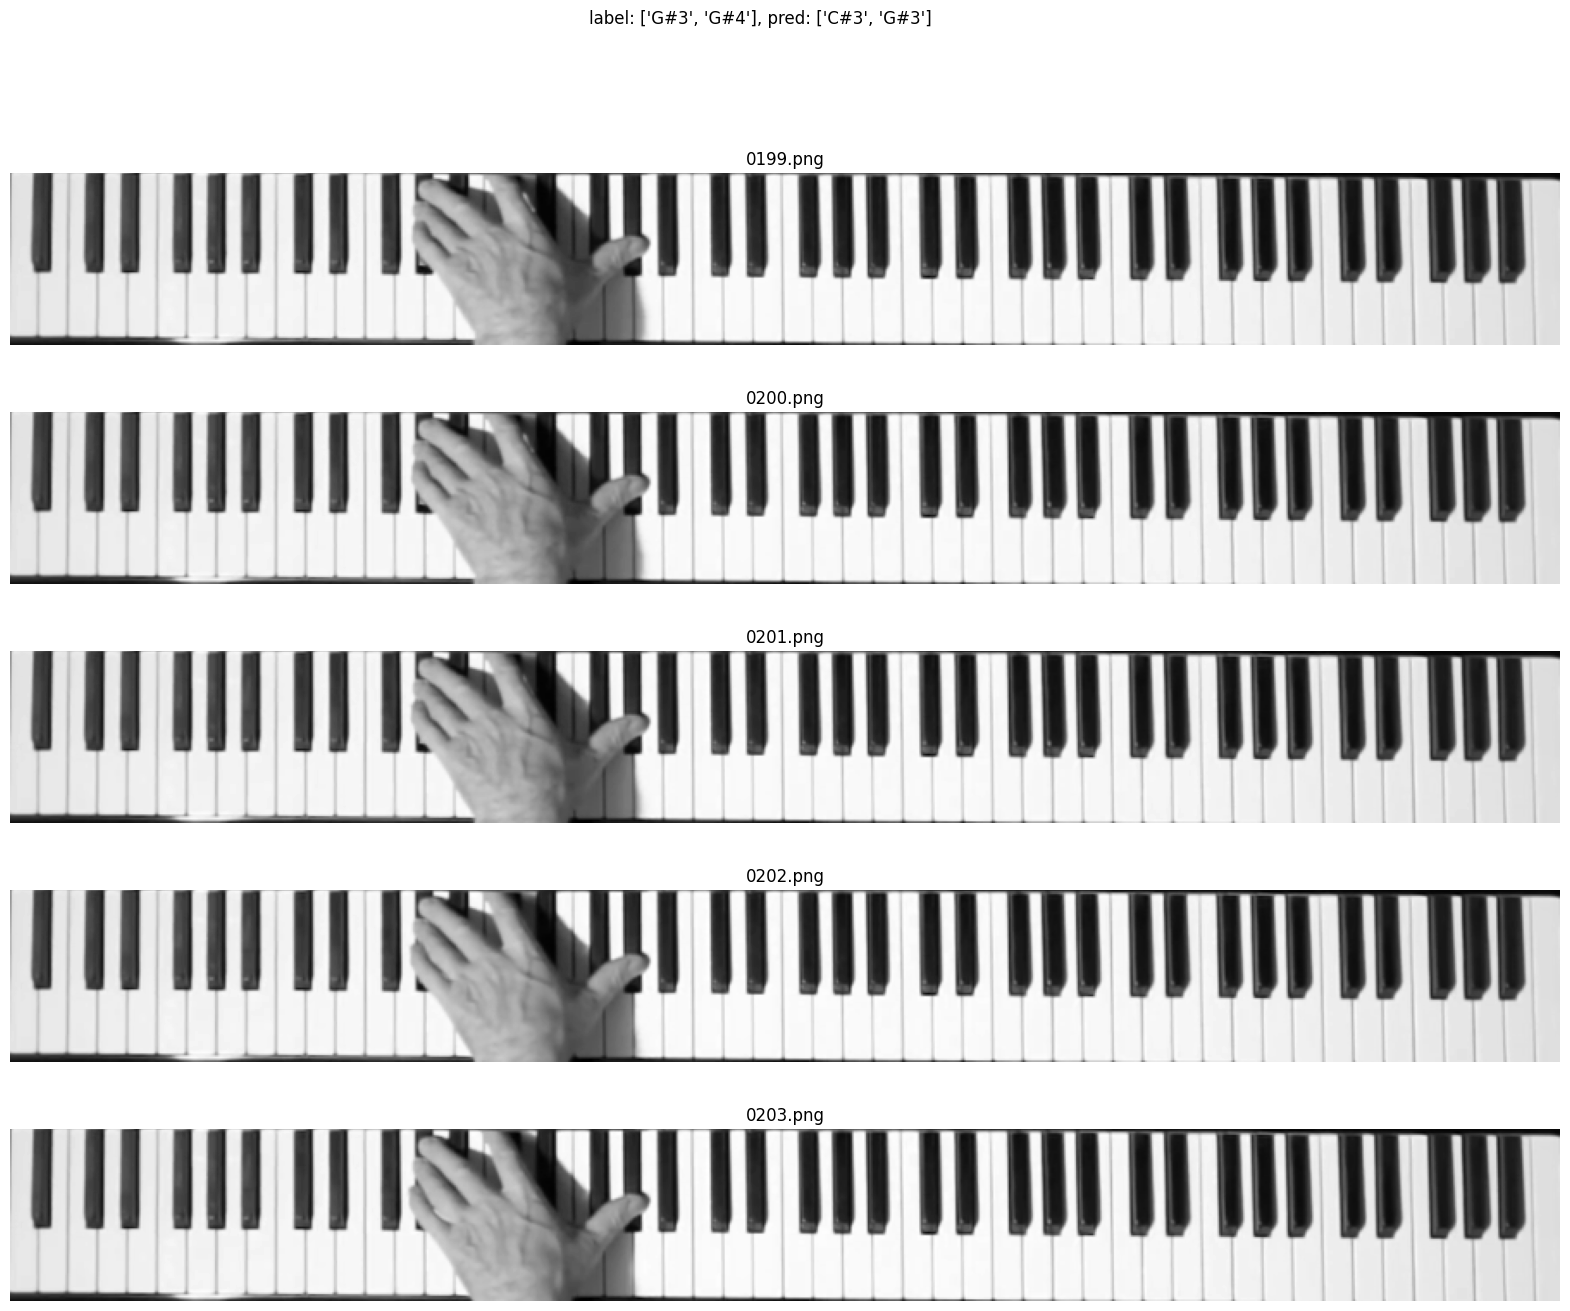

In [400]:
plt.figure(figsize=(20, 15))
plt.suptitle(f"label: {label_notes_h}, pred: {pred_notes_h}")
for i, img in enumerate(full_img_list[idx-2]):
    plt.subplot(5, 1, i+1)
    plt.title(img)
    img = Image.open(os.path.join(image_path, img)).convert('L')
    plt.imshow(img, cmap="gray")
    plt.axis("off")

In [191]:
from dataset import Video2RollDataset

In [154]:
transform = transforms.Compose([lambda x: x.resize((900,100)),
                               lambda x: np.reshape(x,(100,900,1)),
                               lambda x: np.transpose(x,[2,0,1]),
                               lambda x: x/255.])

NameError: name 'transforms' is not defined

In [155]:
ds = Video2RollDataset('./data/ytdataset/images_nopad/', './data/ytdataset/labels_audeo/', transform, 'test')

NameError: name 'transform' is not defined

In [96]:
plt.figure(figsize=(20, 15))
# plt.suptitle(f"label: {label_notes_h}, pred: {pred_notes_h}")
ds_label = np.where(ds[3000][1] == 1)[0]
for i, img in enumerate(ds[3000][0]):
    plt.subplot(5, 1, i+1)
    plt.imshow(img, cmap="gray")
    plt.axis("off")

NameError: name 'ds' is not defined

<Figure size 2000x1500 with 0 Axes>

In [315]:
ds_label

array([ 2,  9, 14, 18, 21, 26, 30, 47, 49, 50])

In [316]:
note_convert_to_char(ds_label)

['B1', 'F#2', 'B2', 'D#3', 'F#3', 'B3', 'D#4', 'G#5', 'A#5', 'B5']

In [374]:
from collections import defaultdict
composers  = defaultdict(int)
for filelist in glob.glob("./data/ytdataset/images_nopad/training/*"):
    composer = filelist.split("/")[-1].split("_")[1].split(" ")[0]
    if composer == 'Bach':
        target_path = os.path.join('/workspace/level3_cv_finalproject-cv-08/data/train_bachonly/images/training', filelist.split("/")[-1])
        original_path = os.path.abspath(filelist)
        # print(target_path)
        # print(original_path)
        # raise Exception
        os.system(f"ln -s '{original_path}' '{target_path}'")
    composers[composer] += 1

In [362]:
sorted(composers.items(), key=lambda x: x[1])

[('Piano', 1),
 ('Happy', 1),
 ('Aquarium', 1),
 ('“Liz', 1),
 ('Spongebob', 1),
 ('Interlude', 1),
 ('“Moon', 1),
 ('Fly', 1),
 ('Dvořák', 1),
 ('Gnossienne', 1),
 ('Rachmaninoff', 1),
 ('“Guilty”', 1),
 ('“The', 1),
 ('Paul', 1),
 ('Moon', 1),
 ('Saint-Saëns', 1),
 ('BachChopin', 1),
 ('“Les', 1),
 ('Elgar', 1),
 ('“Fanfare', 1),
 ('Bach-Friedman', 1),
 ('Lullaby', 1),
 ('Grieg', 1),
 ('“Le', 1),
 ('Mayumi', 1),
 ('Tchaikovsky', 1),
 ('Pachelbel', 1),
 ('Malgré', 1),
 ('Kingdom', 1),
 ('“Waltz', 1),
 ('“God', 1),
 ('Prélude', 1),
 ('MarcelloBach', 1),
 ('Beethoven', 2),
 ('Schumann', 2),
 ('Scott', 2),
 ('Hallelujah', 2),
 ('Scriabin', 2),
 ('Liszt', 3),
 ('Ravel', 3),
 ('Brian', 4),
 ('Erik', 4),
 ('Mozart', 6),
 ('Schubert', 8),
 ('Debussy', 13),
 ('Scarlatti', 19),
 ('Chopin', 29),
 ('Bach', 50)]